In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkConf

spark = SparkSession.builder.appName("Test_spark").master("local[*]").getOrCreate()
sqlCtx = SQLContext(sparkContext=spark.sparkContext, sparkSession=spark)
spark

     |████████████████████████████████| 212.4MB 69kB/s 
     |████████████████████████████████| 204kB 21.4MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=31da04f103159f6b94d057a2d97470059de6e52cefa006fac5cc7196aad55bfe
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving minute_weather.csv.gz to minute_weather.csv.gz


In [ ]:
!gunzip minute_weather.csv.gz

In [ ]:
# Lectura del fichero
mWeatherDf = sqlCtx.read.load('minute_weather.csv', format='com.databricks.spark.csv', header='true', inferSchema='true')
mWeatherDf.count()

1587257

In [ ]:
mWeatherDfFiltered = mWeatherDf.filter((mWeatherDf.rowID % 10) == 0)

finalDF =mWeatherDfFiltered.drop('hpwren_timestamp').drop('rain_accumulation').drop('rain_duration')

finalDF = finalDF.na.drop()
finalDF.count()

158680

In [ ]:
finalDF.toPandas()[:5]

,rowID,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,relative_humidity
0,0,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,60.5
1,10,912.3,62.24,144.0,1.2,167.0,1.8,115.0,0.6,38.5
2,20,912.2,63.32,100.0,2.0,122.0,2.5,91.0,1.5,58.3
3,30,912.2,62.60,91.0,2.0,103.0,2.4,71.0,1.4,57.9
4,40,912.2,64.04,81.0,2.6,88.0,2.9,68.0,1.4,57.4


In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# Construimos el vector
featuresUsed = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 'max_wind_speed', 'relative_humidity']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(finalDF)

In [ ]:
from pyspark.ml.feature import StandardScaler

# Contrsuimos el modelo
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withMean=True , withStd=True)
scalerModel = scaler.fit(assembled)
scalerData = scalerModel.transform(assembled)

In [ ]:
#utils library
from itertools import cycle, islice
from math import sqrt
from numpy import array
from pandas.plotting import parallel_coordinates
from pyspark.ml.clustering import KMeans as KM
from pyspark.mllib.linalg import DenseVector
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Cálculo del coste computancional
def computeCost(featuresAndPrediction, model):
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    arrayCollection = featuresAndPrediction.rdd.map(array)
 
    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        z = point - center
        return sqrt((z*z).sum())
 
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)
 
# Gráfico del error acumulado
def elbow(elbowset, clusters):
    wsseList = []
    ## Comienza a realizar N K-Means
    for k in clusters:
        print("Training for cluster size {}".format(k))
        kmeans = KM(k = k, seed = 1)
        model = kmeans.fit(elbowset)
        transformed = model.transform(elbowset)
        featuresAndPrediction = transformed.select("features", "prediction")
        
        W = computeCost(featuresAndPrediction, model)
        print("......................WSSE = {}".format(W))
        
        wsseList.append(W)
    return wsseList
 
# Plotea la gráfica
def elbow_plot(wsseList, clusters):
    wsseDF = pd.DataFrame({'WSSE' : wsseList, 'k' : clusters })
    wsseDF.plot(y='WSSE', x='k', figsize=(15,10), grid=True, marker='o')
 
def pd_centers(featuresUsed, centers):
    colNames = list(featuresUsed)
    colNames.append('prediction')
 
    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]
 
    # Convert to pandas for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P
 
def parallel_plot(data, P):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(P)))
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [ ]:
scalerData = scalerData.select("features", "rowID")
# Hacemos el cáclulo sobre un tercio de los datos, sino son demasiados
elbowset = scalerData.filter((scalerData.rowID % 3) == 0).select("features")
elbowset.persist()

DataFrame[features: vector]

In [ ]:
clusters = range(2,25)
wsseList = elbow(elbowset,clusters)

Training for cluster size 2
......................WSSE = 117228.9979233905
Training for cluster size 3
......................WSSE = 103495.35420742206
Training for cluster size 4
......................WSSE = 94586.68234188115
Training for cluster size 5
......................WSSE = 91139.2667956011
Training for cluster size 6
......................WSSE = 85087.2210236736
Training for cluster size 7
......................WSSE = 81832.63278657752
Training for cluster size 8
......................WSSE = 79377.41489112313
Training for cluster size 9
......................WSSE = 76637.98160500702
Training for cluster size 10
......................WSSE = 74021.78447395912
Training for cluster size 11
......................WSSE = 73935.48341630568
Training for cluster size 12
......................WSSE = 69819.66134223137
Training for cluster size 13
......................WSSE = 68848.32891230956
Training for cluster size 14
......................WSSE = 67627.48956805709
Training for cluster 

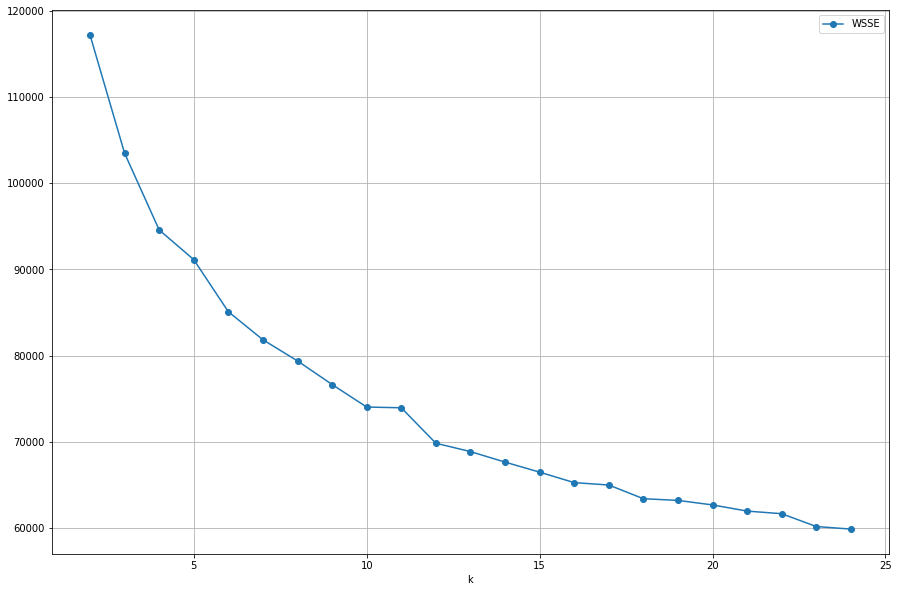

In [ ]:
elbow_plot(wsseList, clusters)

In [26]:
from pyspark.ml.clustering import KMeans
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates
from pyspark.mllib.linalg import DenseVector
import matplotlib.pyplot as plt

In [27]:
scaledDataFeat = scalerData.select("features")
scaledDataFeat.persist()
kmeans = KMeans(k=12, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)
centers = model.clusterCenters()
centers

[array([ 0.31193071, -1.10515968, -1.20684724, -0.5740194 , -1.03920901,
        -0.57936301,  1.07993424]),
 array([ 0.23351408,  0.32066637,  1.88802599, -0.65182056, -1.55151455,
        -0.57651829, -0.2838673 ]),
 array([ 0.30948763,  0.75917911,  1.32559394, -0.63411172,  1.58966255,
        -0.58502263, -0.73899788]),
 array([-0.4338757 ,  0.11613187, -1.17258135, -0.56598772, -1.0498596 ,
        -0.59604043,  0.13662035]),
 array([ 1.44246571, -0.12062683, -1.10201792, -0.09949119, -0.96071048,
        -0.07920465, -0.98449415]),
 array([-1.16139016, -0.83731699,  0.44626299,  1.99066016,  0.5364939 ,
         1.94811864,  0.88038539]),
 array([-0.17202135,  0.61782603,  0.4090396 ,  0.65260512,  0.51893837,
         0.59598055, -0.17946092]),
 array([ 1.18470473, -0.24914106, -1.15442856,  2.09796054, -1.05220352,
         2.21392217, -1.13276907]),
 array([-0.88341971, -1.17891884,  0.37201834,  0.38661636,  0.47274197,
         0.37361112,  1.34268906]),
 array([-0.23216221

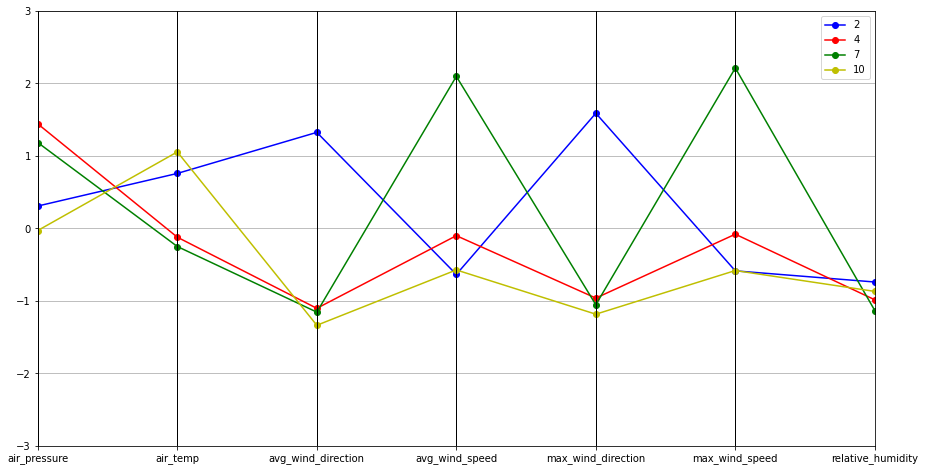

In [ ]:
P = pd_centers(featuresUsed, centers)
parallel_plot(P[P['relative_humidity'] < -0.5], P)

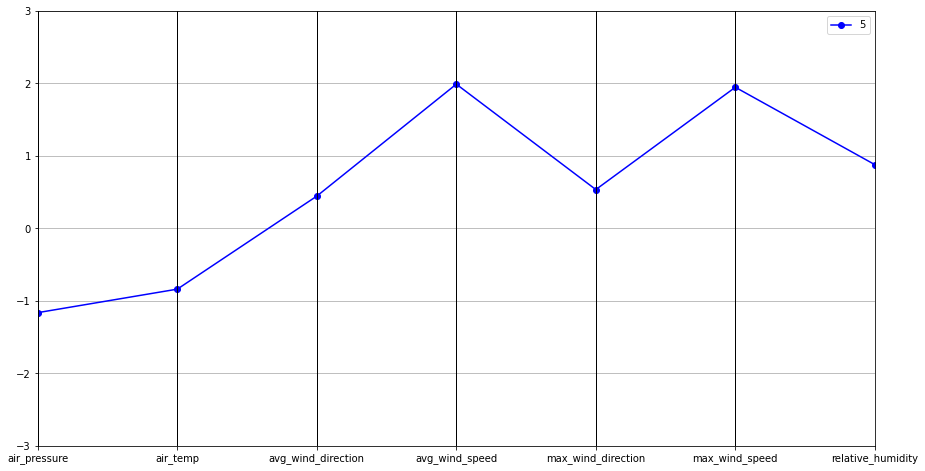

In [ ]:
parallel_plot(P.iloc[[5]], P)

In [25]:
df_join = scalerData.join(transformed, on=['features'], how='inner')
df_join.show()

+--------------------+-------+----------+
|            features|  rowID|prediction|
+--------------------+-------+----------+
|[-3.6472961381669...| 793830|         5|
|[-3.6472961381669...| 793640|         5|
|[-3.4179148341593...| 273310|         5|
|[-2.8608459529977...|1107480|         5|
|[-2.7953084375670...|1155950|         5|
|[-2.7953084375670...|1107500|         5|
|[-2.5986958912747...|1205030|         5|
|[-2.5986958912747...|1307680|         5|
|[-2.5659271335593...| 134670|         8|
|[-2.5331583758439...| 695940|         5|
|[-2.5331583758439...| 134680|         8|
|[-2.5331583758439...|1388800|         5|
|[-2.5003896181285...| 118350|        11|
|[-2.5003896181285...|1155900|         5|
|[-2.4676208604131...|1308360|         5|
|[-2.4676208604131...|1091020|        10|
|[-2.4348521026977...|1308310|         5|
|[-2.2382395564054...|1204890|         5|
|[-2.2382395564054...|1183180|         8|
|[-2.1399332832593...| 273840|         5|
+--------------------+-------+----

In [35]:
(trainingData, testData) = scaledDataFeat.randomSplit([0.8,0.2], seed=13234)

In [36]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Creación del Modelo de LR: Ajuste con k-fold y grid de parámetros.
lr = LinearRegression(labelCol="Type", featuresCol="features")
lrGrid = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.1, 0.05, 0.5]).addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]).build()
lrevaluator = RegressionEvaluator(labelCol="Type")
cv = CrossValidator(estimator = lr, estimatorParamMaps=lrGrid, evaluator= lrevaluator, numFolds=5)
cvModel = cv.fit(trainingData)
 
print(type(cvModel))
print(type(cvModel.bestModel))

IllegalArgumentException: ignored